# Exploratory Data Analysis

In this section we will perform Univariate and Bivariate analysis between features and our target variable (loan status). 
We will summarize and find patterns, distributions of the features then perform the analysis of their relationship with the target variable.

In [57]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew


In [58]:
# Getting a quick overview of the dataset
loan_df= pd.read_csv(r"C:\Users\Bonareri\Machine_Learning_Powered_Credit_Risk_Scoring_System\data\loan.csv")
loan_df.head(2)
loan_df.info()

C:\Users\Bonareri\AppData\Local\Temp\ipykernel_16020\237020207.py:2: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  loan_df= pd.read_csv(r"C:\Users\Bonareri\Machine_Learning_Powered_Credit_Risk_Scoring_System\data\loan.csv")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(74), int64(13), object(24)
memory usage: 33.6+ MB


The dataset contains a total of 111 columns with 39717 entries. However, since our goal is to predict risk at the time of loan application, we will only keep features that would be known before the loan decision is made. These include Loan application details, Borrower demographics and employment, Credit history and behaviour

In [59]:
# Pick only the useful columns for modeling (Those that are available before loan is issued and predictive of a borrower's ability and willingness to repay)
# List of selected columns
selected_columns = [
    # Borrower's profile
    "annual_inc",
    "emp_length",
    "home_ownership",
    "verification_status",
    "purpose",
    "addr_state",

    # Loan details
    "loan_amnt",
    "term",
    "int_rate",
    "installment",
    "grade",
    "sub_grade",

    # Credit history / behavior
    "dti",
    "delinq_2yrs",
    "inq_last_6mths",
    "open_acc",
    "pub_rec",
    "revol_bal",
    "revol_util",
    "total_acc",

    # Target variable
    "loan_status"
]

# Filter dataset to only selected columns
df = loan_df[selected_columns]



In [60]:
# Create a copy of the DataFrame to work with
df1=df.copy()


## Data Inspection.

In [61]:
# Get a quick overview of the dataset
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39717 entries, 0 to 39716
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   annual_inc           39717 non-null  float64
 1   emp_length           38642 non-null  object 
 2   home_ownership       39717 non-null  object 
 3   verification_status  39717 non-null  object 
 4   purpose              39717 non-null  object 
 5   addr_state           39717 non-null  object 
 6   loan_amnt            39717 non-null  int64  
 7   term                 39717 non-null  object 
 8   int_rate             39717 non-null  object 
 9   installment          39717 non-null  float64
 10  grade                39717 non-null  object 
 11  sub_grade            39717 non-null  object 
 12  dti                  39717 non-null  float64
 13  delinq_2yrs          39717 non-null  int64  
 14  inq_last_6mths       39717 non-null  int64  
 15  open_acc             39717 non-null 

In [62]:
df1.head(2)

,annual_inc,emp_length,home_ownership,verification_status,purpose,addr_state,loan_amnt,term,int_rate,installment,...,sub_grade,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,loan_status
0,24000.0,10+ years,RENT,Verified,credit_card,AZ,5000,36 months,10.65%,162.87,...,B2,27.65,0,1,3,0,13648,83.70%,9,Fully Paid
1,30000.0,< 1 year,RENT,Source Verified,car,GA,2500,60 months,15.27%,59.83,...,C4,1.00,0,5,3,0,1687,9.40%,4,Charged Off


In [63]:
# View unique column entries
df1.nunique()

annual_inc              5318
emp_length                11
home_ownership             5
verification_status        3
purpose                   14
addr_state                50
loan_amnt                885
term                       2
int_rate                 371
installment            15383
grade                      7
sub_grade                 35
dti                     2868
delinq_2yrs               11
inq_last_6mths             9
open_acc                  40
pub_rec                    5
revol_bal              21711
revol_util              1089
total_acc                 82
loan_status                3
dtype: int64

In [64]:
# count of null values
(df1.isna().sum()/ len(df1)*100).sort_values(ascending=False)

emp_length             2.706650
revol_util             0.125891
annual_inc             0.000000
verification_status    0.000000
home_ownership         0.000000
purpose                0.000000
addr_state             0.000000
term                   0.000000
loan_amnt              0.000000
installment            0.000000
grade                  0.000000
sub_grade              0.000000
int_rate               0.000000
dti                    0.000000
delinq_2yrs            0.000000
open_acc               0.000000
inq_last_6mths         0.000000
pub_rec                0.000000
revol_bal              0.000000
total_acc              0.000000
loan_status            0.000000
dtype: float64

In [65]:
# Check for duplicates
df1.duplicated().sum()

np.int64(0)

In [66]:
# View unique entries in target variable
df1.loan_status.value_counts()

loan_status
Fully Paid     32950
Charged Off     5627
Current         1140
Name: count, dtype: int64

## Data Cleaning
No major issues with the dataset except for a few wrongly stored columns which we will need to convert their data types and fix the inconsistent entries.
A very little percentage of missing values (2.7% and 0.1%) which we will drop as they will still leave us with just enough data for analysis.
We will also drop rows where loan_status is 'Current' because their final status is unknown.

In [67]:
# 1. Remove % and convert to float
df1['int_rate'] = df1['int_rate'].str.replace('%', '').astype(float)
df1['revol_util'] = df1['revol_util'].str.replace('%', '').astype(float)

In [68]:
# 2. Convert 'term' to integer
df1['term'] = df1['term'].str.replace(' months', '').astype(int)

In [69]:
# 3. Convert emp_length to numeric (extract years)
df1['emp_length'] = df1['emp_length'].replace({'10+ years': '10', '< 1 year': '0', 'n/a': '0'})
df1['emp_length'] = df1['emp_length'].str.extract('(\d+)').astype(float)


In [70]:
# 4. Convert numeric columns to integers or floats
num_cols = ['annual_inc', 'loan_amnt', 'installment', 'dti', 
            'delinq_2yrs', 'inq_last_6mths', 'open_acc', 
            'pub_rec', 'revol_bal', 'total_acc']
df1[num_cols] = df1[num_cols].apply(pd.to_numeric)

In [71]:
# 5. Convert categorical columns
cat_cols = ['home_ownership', 'verification_status', 'purpose', 'addr_state', 'sub_grade', 'loan_status']
df1[cat_cols] = df1[cat_cols].astype('object')

In [72]:
# 6. Drop missing values
df1.dropna(inplace=True)
df1.reset_index(drop=True, inplace=True)


In [73]:
# 7. Drop rows where loan_status is 'Current' because their final status is unknown
# This is important for modeling as we want to predict the final status of loans
df1 = df1[df1['loan_status'] != 'Current']


In [74]:
# Verify data frame after cleaning
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37497 entries, 0 to 38594
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   annual_inc           37497 non-null  float64
 1   emp_length           37497 non-null  float64
 2   home_ownership       37497 non-null  object 
 3   verification_status  37497 non-null  object 
 4   purpose              37497 non-null  object 
 5   addr_state           37497 non-null  object 
 6   loan_amnt            37497 non-null  int64  
 7   term                 37497 non-null  int64  
 8   int_rate             37497 non-null  float64
 9   installment          37497 non-null  float64
 10  grade                37497 non-null  object 
 11  sub_grade            37497 non-null  object 
 12  dti                  37497 non-null  float64
 13  delinq_2yrs          37497 non-null  int64  
 14  inq_last_6mths       37497 non-null  int64  
 15  open_acc             37497 non-null  int6

Everything seems okay now we can proceed to analysis.

In [75]:
#get a statistical summary of the dataset
df1.describe()

,annual_inc,emp_length,loan_amnt,term,int_rate,installment,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
count,3.749700e+04,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000,37497.000000
mean,6.943653e+04,4.943409,11127.362856,41.923034,11.958772,324.858107,13.288131,0.147078,0.872390,9.304264,0.053738,13379.139958,48.861742,22.098035
std,6.467208e+04,3.557394,7353.972102,10.347625,3.682062,208.906836,6.659208,0.493230,1.071211,4.394866,0.234659,15896.953395,28.341493,11.413448
min,4.000000e+03,0.000000,500.000000,36.000000,5.420000,15.690000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,2.000000
25%,4.100000e+04,2.000000,5500.000000,36.000000,8.940000,167.530000,8.160000,0.000000,0.000000,6.000000,0.000000,3711.000000,25.400000,13.000000
50%,6.000000e+04,4.000000,10000.000000,36.000000,11.830000,280.260000,13.390000,0.000000,1.000000,9.000000,0.000000,8856.000000,49.300000,20.000000
75%,8.300000e+04,9.000000,15000.000000,36.000000,14.420000,429.350000,18.550000,0.000000,1.000000,12.000000,0.000000,17017.000000,72.400000,29.000000
max,6.000000e+06,10.000000,35000.000000,60.000000,24.400000,1305.190000,29.990000,11.000000,8.000000,44.000000,4.000000,149588.000000,99.900000,90.000000


# Relationship Analysis Between features and target variable

## 1. Annual Income Vs Loan Status

Skewness of annual_inc: 31.37


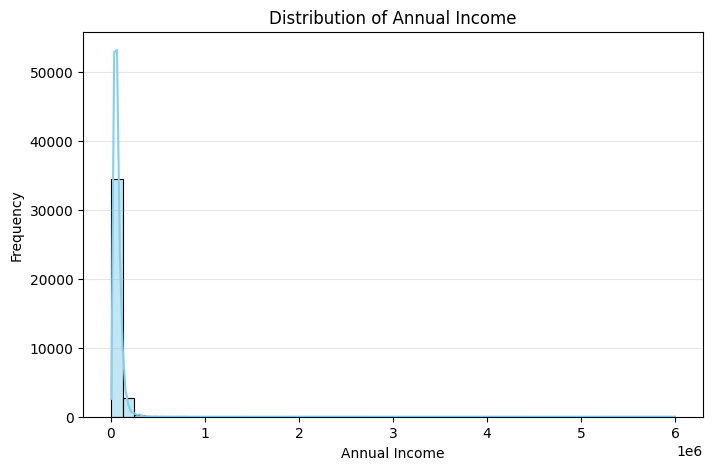

In [76]:
# univariate Analysis.
# First assess the distribution and skewness of annual income
from scipy.stats import skew

# Calculate skewness
skewness_value = skew(df1['annual_inc'])
print(f"Skewness of annual_inc: {skewness_value:.2f}")

# Plot histogram with KDE
plt.figure(figsize=(8, 5))
sns.histplot(df1['annual_inc'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Annual Income")
plt.xlabel("Annual Income")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.3)
plt.show()




### Insights
A skewness of 31.37 is extremely high. Extreme skewness means outliers will dominate the scale and influence model coefficients disproportionately. And many ML algorithms (especially linear models, logistic regression, KNN) assume that features are roughly normally distributed or at least not extremely skewed, So we will need to normalize if we are to get good predictions.

Impact on the target variable (loan_status).
Most borrowers’ annual_inc (annual income) is clustered toward the lower end. A small number of extremely high-income borrowers are pulling the distribution’s tail far to the right. 


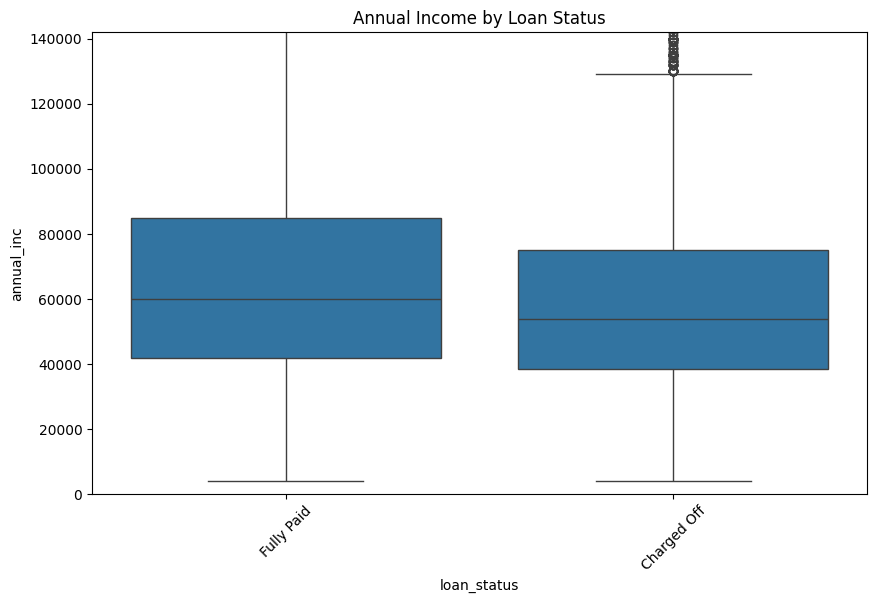

               count          mean           std     min      25%      50%  \
loan_status                                                                  
Charged Off   5384.0  63414.998464  48136.063522  4080.0  38400.0  54000.0   
Fully Paid   32113.0  70446.083406  66994.102369  4000.0  42000.0  60000.0   

                 75%        max  
loan_status                      
Charged Off  75000.0  1250000.0  
Fully Paid   84996.0  6000000.0  


In [77]:
# Bivariate Analysis
# Relationship with Loan Status

# Boxplot for annual_inc by loan_status
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='annual_inc', data=df1)
plt.ylim(0, df1['annual_inc'].quantile(0.95))  # Limit y-axis to reduce effect of extreme outliers
plt.title('Annual Income by Loan Status')
plt.xticks(rotation=45)
plt.show()

# Summary statistics
summary_stats = df1.groupby('loan_status')['annual_inc'].describe()
print(summary_stats)


### Insights
- Pattern: Fully Paid loans tend to have slightly higher median and mean amounts than Charged Off loans.
- Separation Potential: There’s some distinction, but the ranges overlap heavily — meaning loan amount alone may not be a strong predictor of loan status, but it could be useful in combination with other features (e.g., interest rate, borrower income, term length).
- Risk Insight: Very high-value loans appear in both categories, so extremes don’t guarantee repayment. However, the slightly higher typical amounts in fully Paid loans could reflect better-qualified borrowers or different loan types.


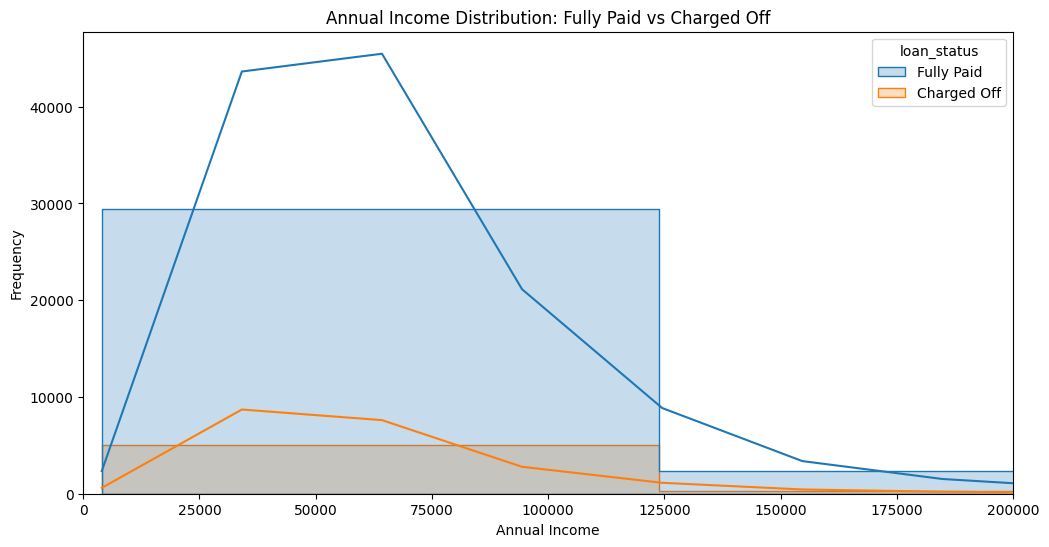

Skewness (Fully Paid): 32.46
Skewness (Charged Off): 7.61


In [78]:

# Assess annual income distribution by loan status 
# Filter only Fully Paid and Charged Off loans
filtered_df1 = df1[df1['loan_status'].isin(['Fully Paid', 'Charged Off'])]

# Set up subplots
plt.figure(figsize=(12,6))

# Plot histogram for both categories
sns.histplot(data=filtered_df1, x='annual_inc', hue='loan_status', kde=True, element='step', bins=50)
plt.title('Annual Income Distribution: Fully Paid vs Charged Off')
plt.xlabel('Annual Income')
plt.ylabel('Frequency')
plt.xlim(0, 200000)  # Cap axis for better visibility (you can adjust)
plt.show()

# Skewness for each category
fully_paid_skew = filtered_df1[filtered_df1['loan_status'] == 'Fully Paid']['annual_inc'].skew()
charged_off_skew = filtered_df1[filtered_df1['loan_status'] == 'Charged Off']['annual_inc'].skew()

print(f"Skewness (Fully Paid): {fully_paid_skew:.2f}")
print(f"Skewness (Charged Off): {charged_off_skew:.2f}")


### Insights
Skewness (Fully Paid) = 32.46. This is extremely right-skewed.
Most borrowers who fully paid their loans had relatively low to moderate annual incomes, but there are a few with extremely high incomes (outliers) pulling the distribution's tail far to the right.

Skewness (Charged Off) = 7.61. This is still right-skewed, but much less extreme than the fully paid group.
Borrowers who defaulted (“Charged Off”) tend to cluster around lower-to-mid income ranges, but still with some high-income outliers — just fewer of them compared to the fully paid group.

What it means...
Since Fully Paid has a much higher skewness than Charged Off, the distribution difference might actually carry predictive power — high-income borrowers appear more likely to be in the “Fully Paid” category.


## 2. Employment Length vs Loan Status

In [79]:
df1.emp_length.sample(10)

27869     3.0
28958     9.0
11520     3.0
33713     1.0
33086     7.0
27756     4.0
34131    10.0
19178     5.0
11746     5.0
907      10.0
Name: emp_length, dtype: float64

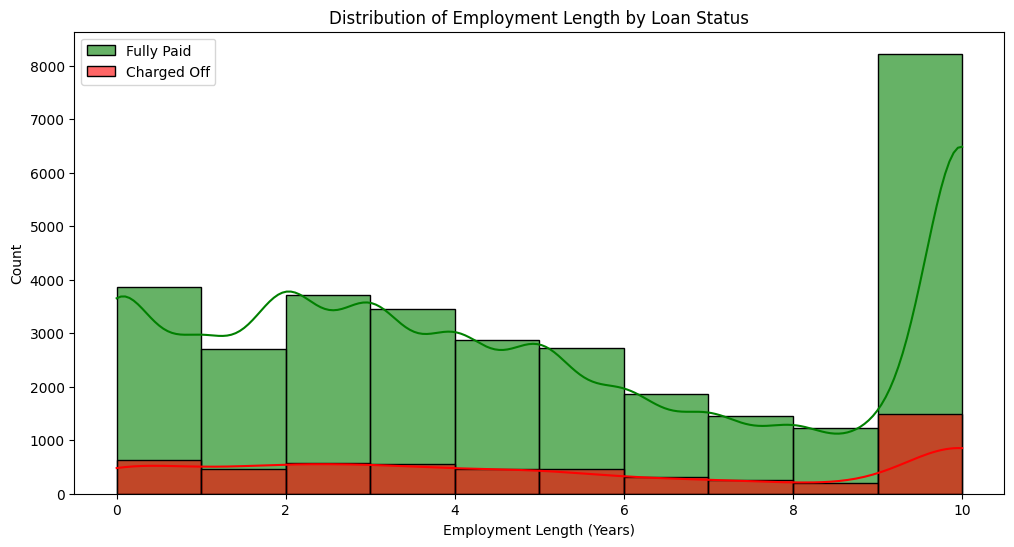

Fully Paid - Mean: 4.919471864976801 Median: 4.0 Skewness: 0.22310748495886099
Charged Off - Mean: 5.086181277860327 Median: 5.0 Skewness: 0.14967055590613157


In [80]:
#Separate the data by loan status
fully_paid = df1[df1['loan_status'] == 'Fully Paid']['emp_length']
charged_off = df1[df1['loan_status'] == 'Charged Off']['emp_length']

# Plot histograms
plt.figure(figsize=(12,6))
sns.histplot(fully_paid, kde=True, color='green', label='Fully Paid', bins=10, alpha=0.6)
sns.histplot(charged_off, kde=True, color='red', label='Charged Off', bins=10, alpha=0.6)

plt.title('Distribution of Employment Length by Loan Status')
plt.xlabel('Employment Length (Years)')
plt.ylabel('Count')
plt.legend()
plt.show()

# Calculate descriptive stats
print("Fully Paid - Mean:", fully_paid.mean(), "Median:", fully_paid.median(), "Skewness:", skew(fully_paid))
print("Charged Off - Mean:", charged_off.mean(), "Median:", charged_off.median(), "Skewness:", skew(charged_off))


### Insights
Fully Paid Loans:
Mean (4.92): On average, borrowers who fully paid their loans had about 4.92 years of employment.
Median (4.0): Half of these borrowers had 4 years or less of employment, meaning there are a few with much longer employment that slightly push up the mean.
Skewness (0.22): Very close to 0, indicating the distribution is almost symmetrical — there’s no heavy tail in either direction.

Charged Off Loans:
Mean (5.09): On average, borrowers who defaulted had about 5.09 years of employment.
Median (5.0): Exactly half had 5 years or less of employment, again showing symmetry between lower and higher values.
Skewness (0.15): Even closer to zero, meaning the distribution is also nearly symmetrical.

Implications for Modeling:
Employment length is not heavily skewed for either group — no need for log transformation.
Means and medians are quite similar between the two groups, suggesting that emp_length might not be a strong predictor for loan status on its own.
However, it could still be useful when combined with other features.

#### What the graph means
Distribution Shape:

Both Fully Paid and Charged Off loans have borrowers spread across all employment lengths, from 0 years to 10+ years.
There’s a noticeable spike at 10 years for both groups — meaning many borrowers report a decade or more of work experience.
There’s also a decent number of borrowers with 0 years of employment — which could indicate either being new to the workforce or self-employed with less reported history.

Comparison Between Fully Paid & Charged Off:
Fully Paid loans dominate across every employment length category — especially in the 10+ years category.
The relative proportion of Charged Off loans seems slightly higher at the very low (0 years) and moderate (5–7 years) ranges than at the high (10+ years) range.
However, the difference in shape between the two groups isn’t extreme — meaning employment length alone might not be a strong discriminator.

Risk Implications:
Longer employment length appears to slightly correlate with higher repayment rates — the spike at 10+ years is heavily skewed toward Fully Paid loans.
Borrowers with very short employment history (0–2 years) have a higher relative chance of default compared to the long-term employed group — but the effect size looks modest.

Feature Selection Note:
Employment length could be kept as a feature, but it’s unlikely to be a top predictor on its own. It might work better in combination with other variables.


## 3. Home Ownership Vs Loan Status

Frequency Table:
 loan_status     Charged Off  Fully Paid
home_ownership                         
MORTGAGE               2242       14344
NONE                      0           3
OTHER                    18          78
OWN                     398        2367
RENT                   2726       15321

Percentage Distribution:
 loan_status     Charged Off  Fully Paid
home_ownership                         
MORTGAGE              13.52       86.48
NONE                   0.00      100.00
OTHER                 18.75       81.25
OWN                   14.39       85.61
RENT                  15.11       84.89


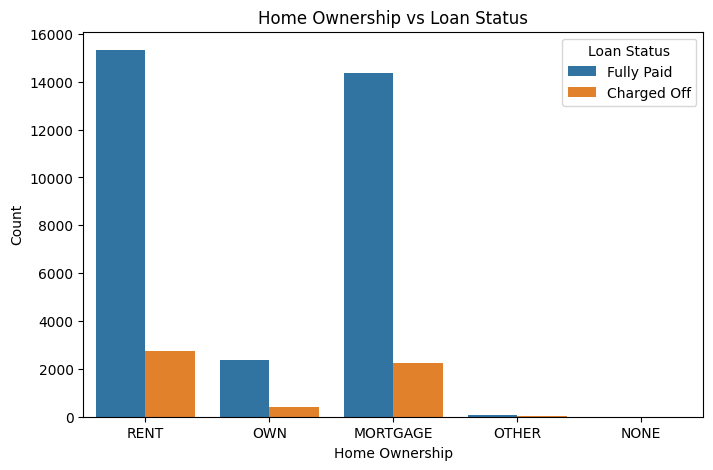

In [81]:

# 1. Frequency table
home_loan_counts = pd.crosstab(df1['home_ownership'], df1['loan_status'])
print("Frequency Table:\n", home_loan_counts)

# 2. Percentage distribution
home_loan_percent = pd.crosstab(df1['home_ownership'], df1['loan_status'], normalize='index') * 100
print("\nPercentage Distribution:\n", home_loan_percent.round(2))

# 3. Visualization
plt.figure(figsize=(8,5))
sns.countplot(data=df1, x='home_ownership', hue='loan_status')
plt.title("Home Ownership vs Loan Status")
plt.xlabel("Home Ownership")
plt.ylabel("Count")
plt.legend(title="Loan Status")
plt.show()


### Insights. 

Raw Counts of Loans based on home ownership:
MORTGAGE borrowers dominate the dataset with 16,586 loans, followed by RENT borrowers with 18,047 loans.
OWN borrowers (no mortgage) are far fewer: 2,765 loans.
OTHER and NONE are negligible in number and won’t contribute much statistically.

Percentage Distribution (Risk View)

Lowest default risk:
MORTGAGE borrowers: 13.52% Charged Off → likely more financially stable, possibly due to having property equity.
OWN borrowers: 14.39% Charged Off → similar stability, though slightly riskier than mortgage holders.

Highest default risk:
OTHER category: 18.75% Charged Off → possibly unstable or unconventional housing situations.
RENT borrowers: 15.11% Charged Off → slightly higher risk than homeowners.

NONE has zero defaults, but the sample size (3 loans) is too small to be meaningful.

Implication for Feature Selection:
Home ownership clearly affects the target variable because default rates differ across categories.
Mortgage holders tend to be safer borrowers.
Renters have a moderately higher risk.

Other/None categories have too little data for strong conclusions but could be grouped together or dropped to avoid noise.

## 4. Verification Status vs Loan Status

Frequency Table:
loan_status          Charged Off  Fully Paid
verification_status                         
Not Verified                2042       14208
Source Verified             1393        8090
Verified                    1949        9815

Percentage Distribution:
loan_status          Charged Off  Fully Paid
verification_status                         
Not Verified               12.57       87.43
Source Verified            14.69       85.31
Verified                   16.57       83.43


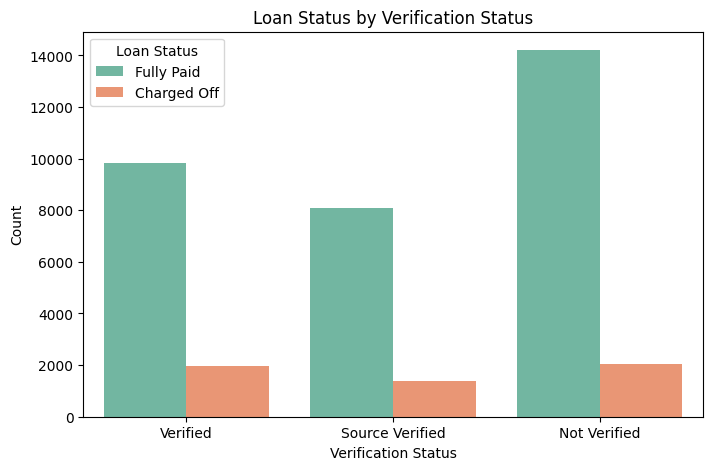

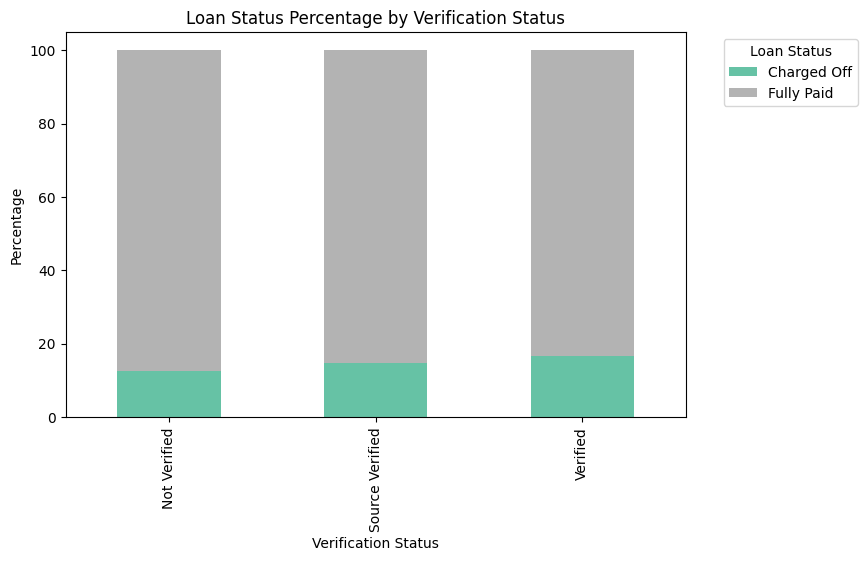

In [82]:

# Frequency table
freq_table = df1.groupby(['verification_status', 'loan_status']).size().unstack(fill_value=0)

print("Frequency Table:")
print(freq_table)

# Percentage distribution
percentage_table = freq_table.div(freq_table.sum(axis=1), axis=0) * 100
print("\nPercentage Distribution:")
print(percentage_table.round(2))

# Visualization 1: Count Plot 
plt.figure(figsize=(8, 5))
sns.countplot(data=df1, x='verification_status', hue='loan_status', palette='Set2')
plt.title('Loan Status by Verification Status')
plt.xlabel('Verification Status')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()

# Visualization 2: Percentage Stacked Bar 
percentage_table.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='Set2')
plt.title('Loan Status Percentage by Verification Status')
plt.xlabel('Verification Status')
plt.ylabel('Percentage')
plt.legend(title='Loan Status', bbox_to_anchor=(1.05, 1))
plt.show()



### Insights.
Observations from the frequency table.
Most borrowers are Fully Paid regardless of verification status. For instance Not Verified has 14,552 fully paid loans out of 16,921 total in that group.
Charged Off loans are highest in the Verified group (2,051 loans) in absolute count — but that’s because there are more verified loans overall compared to Source Verified.

Insights from the percentage distribution.
Default rate (Charged Off) increases with verification strictness:
Not Verified - 12.57% default rate
Source Verified - 14.69% default rate
Verified → 16.57% default rate

This is counterintuitive, you’d expect stricter verification to reduce defaults. This might indicate that higher-risk applicants are more likely to undergo verification.

Fully paid proportion decreases as verification level increases:
Not Verified - 87.43%
Source Verified - 85.31%
Verified - 83.43%

Again, this suggests that verified loans are possibly riskier or larger amounts, and not all have reached full repayment yet.

Key takeaway

The verification process isn’t a strong predictor of repayment success in this dataset.

Instead, it may be used more for risk management — loans that look risky get more scrutiny (hence “verified”) but also tend to default more.

#### What the graph means
Fully Paid loans dominate all verification categories
The Fully Paid bars are significantly taller than the other categories in all three verification statuses.
This means most borrowers, regardless of whether they were verified, source verified, or not verified, end up repaying their loans fully.

Charged Off loans show a slight pattern
The Charged Off bars are smallest in Source Verified, larger in Verified and Not Verified.
This mirrors what we saw in the percentage table — the default rate (Charged Off) is not drastically different but is slightly higher for Verified and Not Verified groups.

Interpretation in terms of risk prediction:
Since the Fully Paid counts are dominant in all categories, verification status alone is a weak discriminator for loan status.
The slightly higher Charged Off counts in Verified loans may be due to risk-based verification (riskier applicants are more likely to be verified).

## 5. Loan purpose vs loan status

loan_status         Charged Off  Fully Paid
purpose                                    
car                   10.650069   89.349931
credit_card           10.394119   89.605881
debt_consolidation    15.138134   84.861866
educational           16.560510   83.439490
home_improvement      11.790079   88.209921
house                 16.666667   83.333333
major_purchase        10.125362   89.874638
medical               15.290520   84.709480
moving                15.272727   84.727273
other                 16.000000   84.000000
renewable_energy      19.148936   80.851064
small_business        27.033353   72.966647
vacation              14.409222   85.590778
wedding               10.087719   89.912281


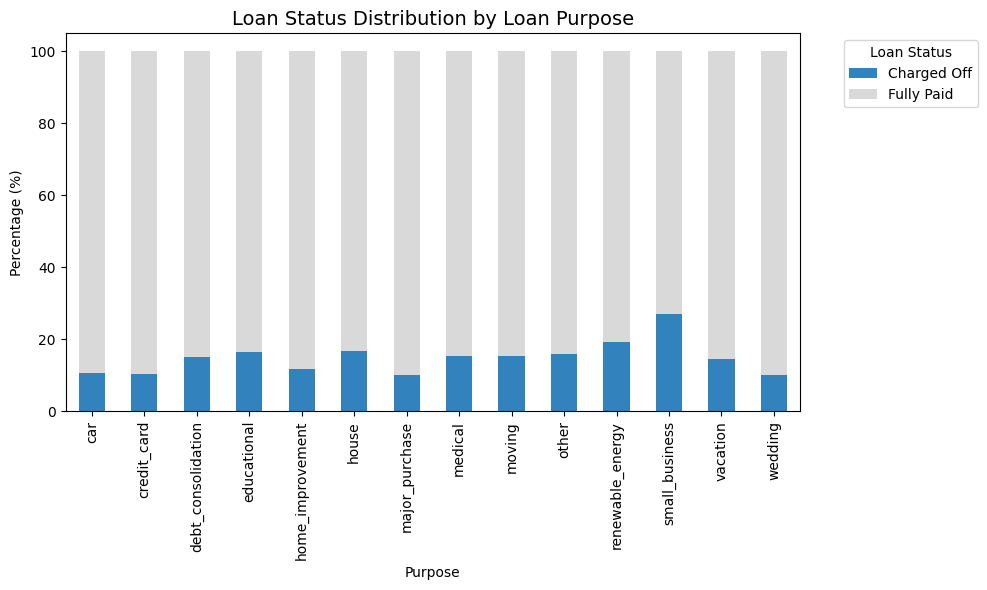

In [83]:
# Cross-tabulation
purpose_status_ct = pd.crosstab(df1['purpose'], df1['loan_status'], normalize='index') * 100
print(purpose_status_ct)

# Visualization - Stacked bar chart
purpose_status_ct.plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20c')
plt.title("Loan Status Distribution by Loan Purpose", fontsize=14)
plt.ylabel("Percentage (%)")
plt.xlabel("Purpose")
plt.legend(title="Loan Status", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### Insights
Lowest risk purposes (lowest Charged Off %):
Wedding - 10.09% Charged Off
Credit Card - 10.39% Charged Off
Car - 10.65% Charged Off
Major Purchase - 10.13% Charged Off
These categories show high repayment reliability, which might suggest they’re safer lending areas.

Moderate risk purposes (~15–17% Charged Off):
Debt Consolidation -15.14%
Medical - 15.29%
Moving - 15.27%
Educational - 16.56%
House - 16.67% 
Other - 16.00%
These purposes carry more risk than car or credit card loans, but not extreme.

High risk purposes:
Renewable Energy - 19.15% Charged Off
Small Business - 27.03% Charged Off — the riskiest category by far, meaning more than 1 in 4 loans default.

Impact on the target variable:
Purpose clearly influences loan repayment probability. The variance between 10% and 27% Charged Off rates is significant. This makes purpose a strong candidate feature for the risk model. 

## 6. Address State vs Loan Status

loan_status  Charged Off  Fully Paid
addr_state                          
NE             60.000000   40.000000
NV             21.814255   78.185745
AK             19.736842   80.263158
SD             18.333333   81.666667
FL             17.861121   82.138879
HI             17.391304   82.608696
ID             16.666667   83.333333
MO             16.383308   83.616692
NM             16.201117   83.798883
OR             16.190476   83.809524
CA             15.870433   84.129567
GA             15.845337   84.154663
UT             15.789474   84.210526
NJ             15.655133   84.344867
MD             15.653041   84.346959
NC             15.172414   84.827586
WA             15.070243   84.929757
KY             14.657980   85.342020
NH             14.649682   85.350318
MI             14.456036   85.543964
SC             14.190687   85.809313
OK             14.184397   85.815603
AZ             14.072229   85.927771
WI             13.647059   86.352941
IL             13.462873   86.537127
M

<Figure size 1200x600 with 0 Axes>

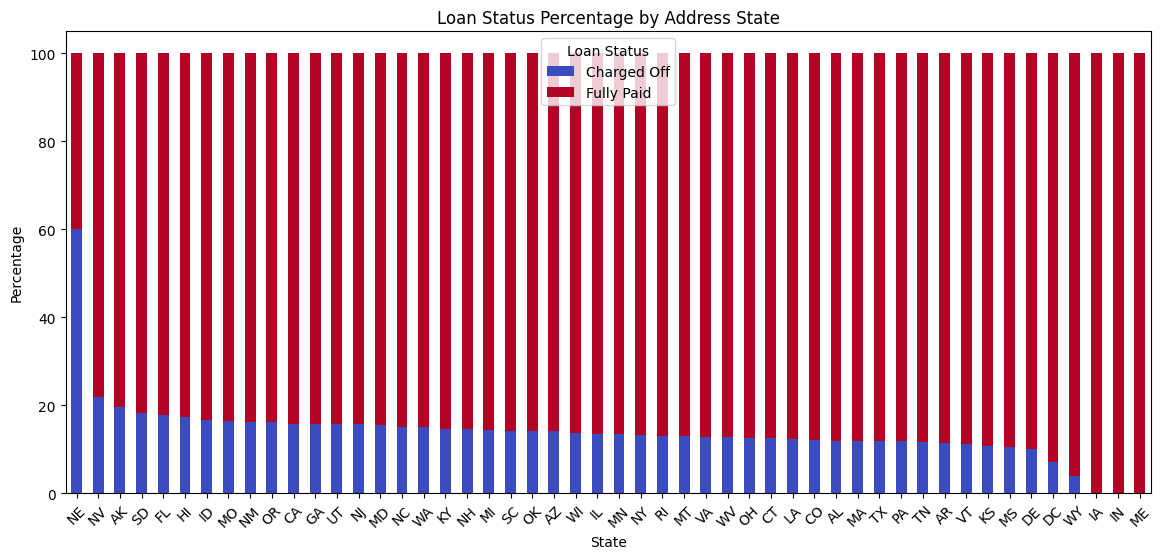

In [84]:
# cross-tabulation (counts)
state_status_counts = pd.crosstab(df1['addr_state'], df1['loan_status'])

# Convert counts to percentages for easier comparison
state_status_percent = state_status_counts.div(state_status_counts.sum(axis=1), axis=0) * 100

# Display results sorted by percentage of 'Charged Off'
state_status_percent_sorted = state_status_percent.sort_values(by='Charged Off', ascending=False)

print(state_status_percent_sorted)

# Visualization
plt.figure(figsize=(12, 6))
state_status_percent_sorted.plot(kind='bar', stacked=True, figsize=(14,6), colormap='coolwarm')
plt.title('Loan Status Percentage by Address State')
plt.ylabel('Percentage')
plt.xlabel('State')
plt.legend(title='Loan Status')
plt.xticks(rotation=45)
plt.show()


### Insights
High Default States:
NE stands out significantly with an extremely high Charged Off rate (around 60%), which is far above the national average.
NV also shows elevated defaults (~22%).

Low Default States:
ME, LA, IN have almost negligible Charged Off percentages, indicating very low risk in these states.

Majority States:
Most states fall in the 10–20% Charged Off range, indicating similar loan repayment behavior.

Implications:
addr_state may contain geographical risk signals — certain states have disproportionately high or low default rates.




## 7. Loan amount vs loan status

count    37497.000000
mean     11127.362856
std       7353.972102
min        500.000000
25%       5500.000000
50%      10000.000000
75%      15000.000000
max      35000.000000
Name: loan_amnt, dtype: float64
loan_status
Fully Paid     32113
Charged Off     5384
Name: count, dtype: int64

Loan Amount Summary by Loan Status:
   loan_status  count          mean   median          std
0  Charged Off   5384  12263.331166  10000.0  8085.876175
1   Fully Paid  32113  10936.908729   9600.0  7206.638295


C:\Users\Bonareri\AppData\Local\Temp\ipykernel_16020\3606106577.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df1, x='loan_status', y='loan_amnt', palette='Set2')


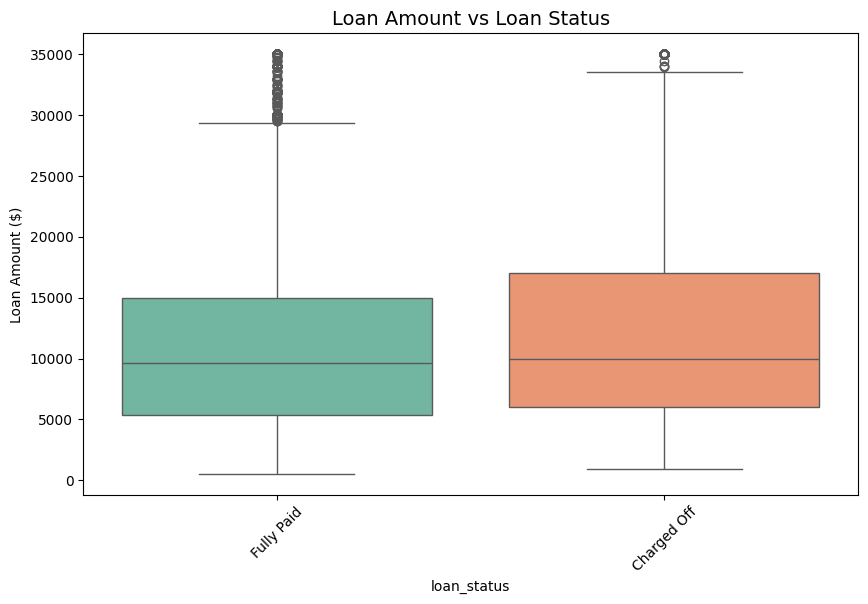

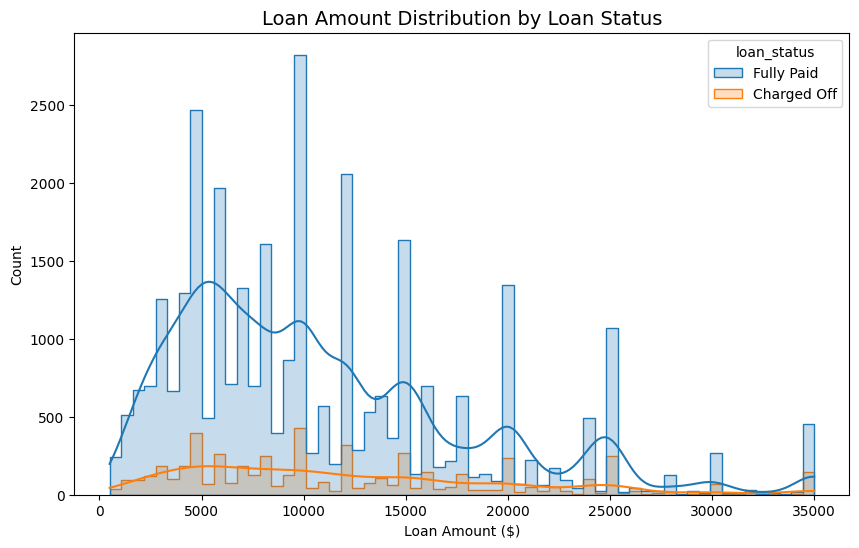

In [85]:

# Quick check
print(df1['loan_amnt'].describe())
print(df1['loan_status'].value_counts())

# Summary statistics per loan status
loan_summary = df1.groupby('loan_status')['loan_amnt'].agg(['count', 'mean', 'median', 'std']).reset_index()
print("\nLoan Amount Summary by Loan Status:")
print(loan_summary)

# Visualization
plt.figure(figsize=(10,6))
sns.boxplot(data=df1, x='loan_status', y='loan_amnt', palette='Set2')
plt.title("Loan Amount vs Loan Status", fontsize=14)
plt.ylabel("Loan Amount ($)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(data=df1, x='loan_amnt', hue='loan_status', kde=True, element='step')
plt.title("Loan Amount Distribution by Loan Status", fontsize=14)
plt.xlabel("Loan Amount ($)")
plt.show()


### Insights
Overall Loan Amount Distribution

Count: 37,497 loans in total.

Mean: Average loan amount is $11,127, but the high standard deviation ($7,354) tells us amounts vary a lot.

Range: From as low as $500 to as high as $35,000.

Percentiles:

25% of loans are ≤ $5,500.

50% (median) is $10,000.

75% are ≤ $15,000.

Loan Amount vs Loan Status

Fully Paid Loans

Count: 32,113 (≈85.6% of loans).

Mean: $10,937 (lower than overall mean).

Median: $9,600.

Std Dev: $7,207 (slightly less variability than charged-off loans).

Charged Off Loans

Count: 5,384 (≈14.4% of loans).

Mean: $12,263 (about $1,300 higher than fully paid loans).

Median: $10,000.

Std Dev: $8,086 (more spread — indicates some very large high-risk loans).

Key Interpretation:

Higher Loan Amounts = Higher Default Risk:
Borrowers who defaulted (“Charged Off”) had on average larger loans than those who fully repaid.

Risk Pattern:
The higher standard deviation among charged-off loans suggests large loan amounts are more unpredictable in repayment.

Possible Insight:
Lending policies might need stricter approval criteria or better risk-based interest rates for loans above $12K–$15K.

Loan Amount appears to have some relationship with Loan Status
Charged Off loans have a higher average loan amount (~12,263) compared to Fully Paid loans (~10,937).
The spread (std) is also slightly larger for Charged Off loans, meaning there’s more variability in loan amounts for those that default.
This suggests that borrowers taking larger loans may be more likely to default, although the difference is not extremely large.

The difference is modest but could still be predictive
The difference in means (~$1,326) is noticeable, but loan amount alone won’t be a strong predictor of loan status.
It should still be included in the model, but it will work best in combination with other features (income, debt-to-income ratio, interest rate, etc.).

For modeling
Keep loan_amnt as a feature — it likely has some predictive power.


## 8. Term vs Loan Status

loan_status  Charged Off  Fully Paid
term                                
36             10.838084   89.161916
60             25.102658   74.897342


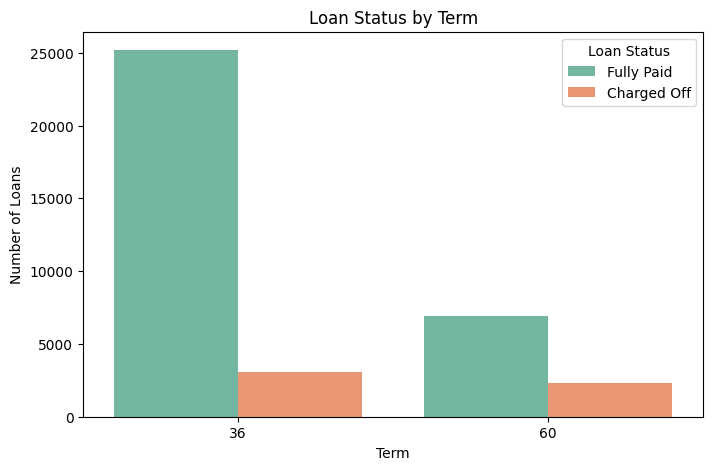

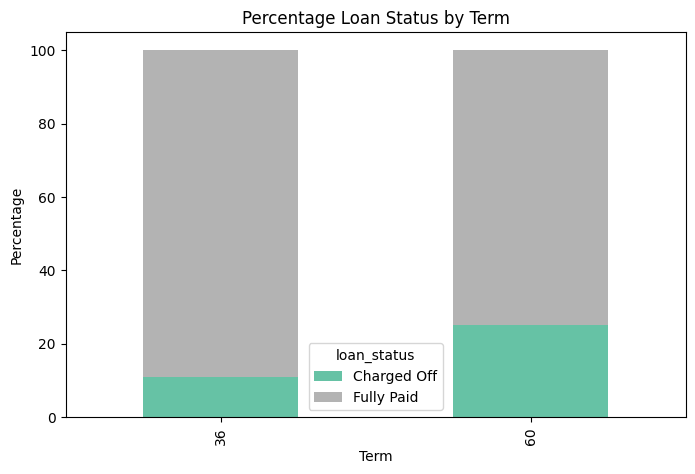

In [86]:
# Crosstab of term vs loan_status
term_status_ct = pd.crosstab(df1['term'], df1['loan_status'], normalize='index') * 100
print(term_status_ct)

# Countplot for visualization
plt.figure(figsize=(8,5))
sns.countplot(data=df1, x='term', hue='loan_status', palette='Set2')
plt.title('Loan Status by Term')
plt.xlabel('Term')
plt.ylabel('Number of Loans')
plt.legend(title='Loan Status')
plt.show()

# Percentage stacked bar chart
term_status_ct.plot(kind='bar', stacked=True, colormap='Set2', figsize=(8,5))
plt.title('Percentage Loan Status by Term')
plt.ylabel('Percentage')
plt.xlabel('Term')
plt.show()


### Insights
Loans with a longer term (60 months) are more than twice as likely to default (Charged Off) compared to shorter-term loans (36 months).
This suggests term length is a potentially strong predictor for loan repayment outcomes and should be included in our model.
36-month loans have a much lower default risk — only ~10.8% charged off, meaning most borrowers complete repayment successfully.

60-month loans carry significantly higher risk — about 25.1% charged off, more than double the short-term loan default rate.
This likely reflects the fact that longer repayment periods increase uncertainty:
Borrowers are exposed to more financial or personal changes over time (job loss, economic downturn, etc.).
The total interest paid is higher, which might strain borrowers’ ability to continue payments.

Implication for lenders: Favoring shorter-term loans could reduce default exposure, or if issuing long-term loans, consider higher interest rates, stricter eligibility criteria, or collateral requirements to offset the additional risk.

## 9. Interest rate vs loan status

   loan_status   int_rate
0  Charged Off  13.874783
1   Fully Paid  11.637537


C:\Users\Bonareri\AppData\Local\Temp\ipykernel_16020\2902058347.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="loan_status", y="int_rate", data=df1, palette="viridis")


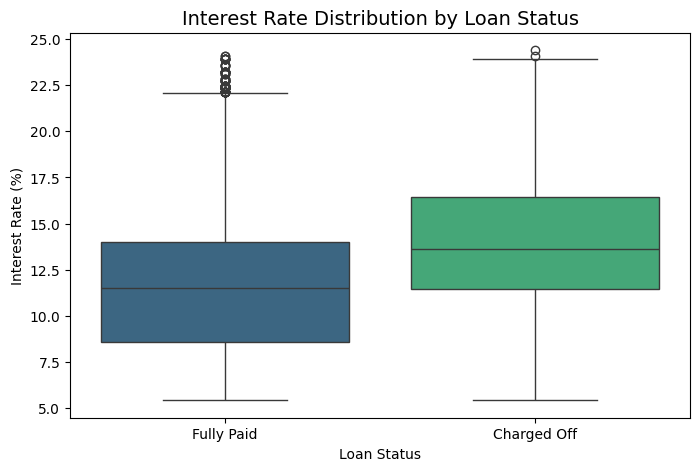

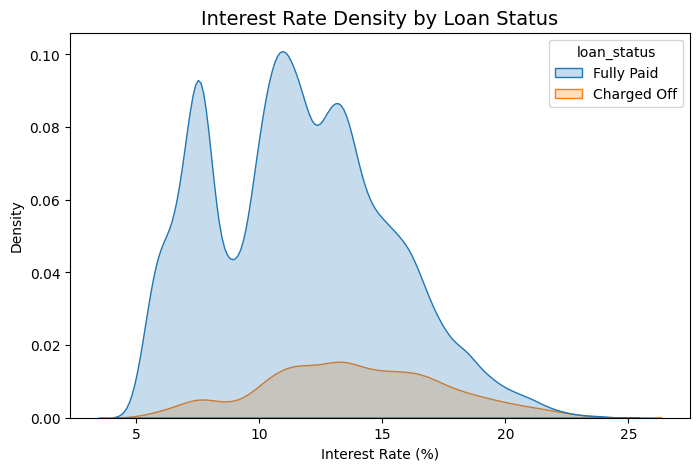

In [87]:

# Crosstab for interest rate by loan status (mean values)
int_rate_summary = df1.groupby("loan_status")["int_rate"].mean().reset_index()

# Display summary
print(int_rate_summary)

# Visualization
plt.figure(figsize=(8,5))
sns.boxplot(x="loan_status", y="int_rate", data=df1, palette="viridis")
plt.title("Interest Rate Distribution by Loan Status", fontsize=14)
plt.xlabel("Loan Status")
plt.ylabel("Interest Rate (%)")
plt.show()

# Optional: KDE plot for a better sense of distribution
plt.figure(figsize=(8,5))
sns.kdeplot(data=df1, x="int_rate", hue="loan_status", fill=True)
plt.title("Interest Rate Density by Loan Status", fontsize=14)
plt.xlabel("Interest Rate (%)")
plt.ylabel("Density")
plt.show()


### Insights
Charged Off loans: Average interest rate = 13.87%.

Fully Paid loans: Average interest rate = 11.64%.

Credit risk insight:
Borrowers paying higher interest rates are more likely to default. This makes sense because higher interest rates are often assigned to borrowers with lower creditworthiness — and the repayment burden is heavier.

## 10. Installment vs loan status

   loan_status  installment
0  Charged Off   340.350507
1   Fully Paid   322.260683


C:\Users\Bonareri\AppData\Local\Temp\ipykernel_16020\3657090883.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="loan_status", y="installment", data=df1, palette="Set2")


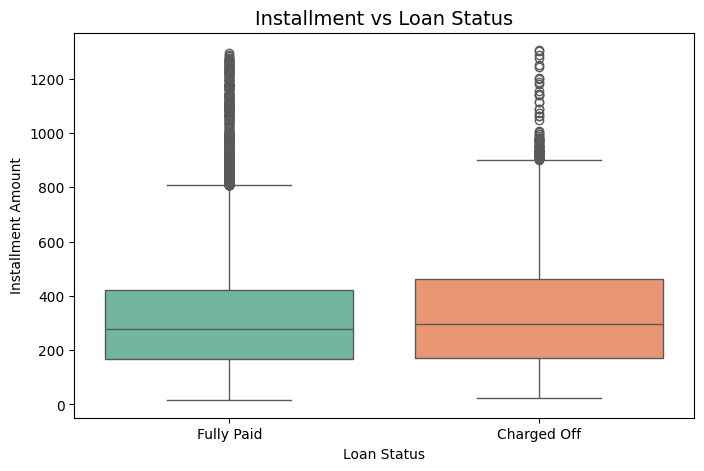

In [88]:

# Group by loan_status and calculate average installment
installment_summary = df1.groupby("loan_status")["installment"].mean().reset_index()

print(installment_summary)

# Visualization: Boxplot to show distribution of installment by loan status
plt.figure(figsize=(8, 5))
sns.boxplot(x="loan_status", y="installment", data=df1, palette="Set2")
plt.title("Installment vs Loan Status", fontsize=14)
plt.xlabel("Loan Status")
plt.ylabel("Installment Amount")
plt.show()


### Insights
Charged Off loans have a higher average installment of about $340.35 compared to $322.26 for Fully Paid loans.This suggests that borrowers with higher monthly installments are more likely to default (Charged Off) than those with lower installments.
From a credit risk perspective, larger installment amounts could place a greater repayment burden on borrowers, increasing the probability of non-payment, especially if their income is not sufficiently high or stable.

Lenders might need to closely assess affordability when approving loans with higher installments, perhaps by tightening debt-to-income ratio requirements or offering lower installment amounts via extended terms.

Since the average installment differs between Charged Off and Fully Paid loans, installment likely has some predictive power for loan_status.
The difference (≈ $18) is not huge, but it could still be statistically significant, depending on the dataset size and variance.

In feature selection terms, installment should be considered as a candidate predictor, but it might not be the strongest feature on its own — it could work better in combination with other features (e.g., income, loan amount, term, interest rate).

## 11. Grade vs Loan Status

loan_status  Charged Off  Fully Paid
grade                               
A               5.776398   94.223602
B              11.929917   88.070083
C              16.782030   83.217970
D              21.801330   78.198670
E              26.676888   73.323112
F              32.494759   67.505241
G              33.108108   66.891892


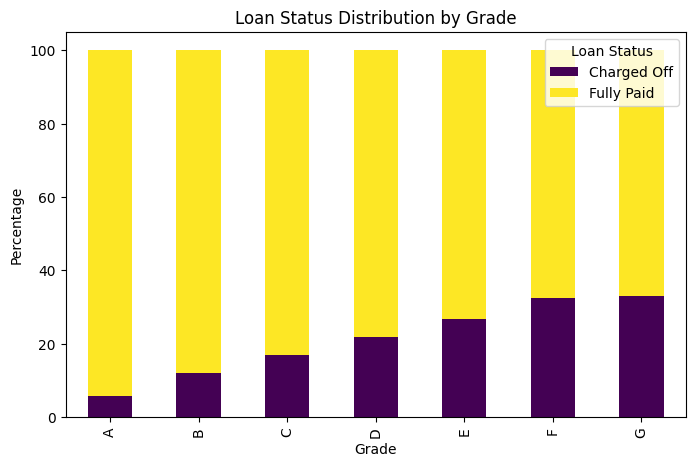

In [89]:

# Crosstab for grade vs loan_status
grade_status = pd.crosstab(df1['grade'], df1['loan_status'], normalize='index') * 100
print(grade_status)

# Plot stacked bar chart
grade_status.plot(kind="bar", stacked=True, figsize=(8,5), colormap="viridis")
plt.title("Loan Status Distribution by Grade")
plt.ylabel("Percentage")
plt.xlabel("Grade")
plt.legend(title="Loan Status")
plt.show()


### Insights
Grade A loans have the lowest credit risk, with only ~5.8% charged off and ~94.2% fully paid.

As you move down the grades (A → G), the probability of charge-off increases significantly:

Grade B: ~11.9% charged off.

Grade C: ~16.8% charged off.

Grade D: ~21.8% charged off.

Grade E: ~26.7% charged off.

Grade F: ~32.5% charged off.

Grade G: ~33.1% charged off.

This shows a clear monotonic trend: lower credit grades (A → G) correspond to higher default (charge-off) rates.

Credit Risk Perspective:

Grade is a strong proxy for borrower creditworthiness.

Lenders can rely on grade as a risk stratification tool — higher grade loans are safer, lower grade loans are riskier.

The steep increase in defaults from A to G reinforces why lenders often adjust interest rates by grade.

Feature Selection Perspective:
Grade is a highly predictive categorical feature for credit risk models.
The monotonic increase in default rate suggests it has strong explanatory power for loan_status.
It should definitely be included in feature selection for credit risk modeling

## 12. Sub grade vs Loan status

loan_status  Charged Off  Fully Paid
sub_grade                           
A1              2.281369   97.718631
A2              4.718945   95.281055
A3              5.169443   94.830557
A4              6.017192   93.982808
A5              7.896735   92.103265
B1              8.943089   91.056911
B2             10.853909   89.146091
B3             11.871814   88.128186
B4             13.322162   86.677838
B5             13.520907   86.479093
C1             15.904573   84.095427
C2             16.094987   83.905013
C3             17.788462   82.211538
C4             17.276596   82.723404
C5             17.694370   82.305630
D1             17.782656   82.217344
D2             20.766773   79.233227
D3             22.836096   77.163904
D4             23.034330   76.965670
D5             25.154131   74.845869
E1             27.144866   72.855134
E2             26.411960   73.588040
E3             22.954092   77.045908
E4             29.594272   70.405728
E5             27.925532   72.074468
F

<Figure size 1200x600 with 0 Axes>

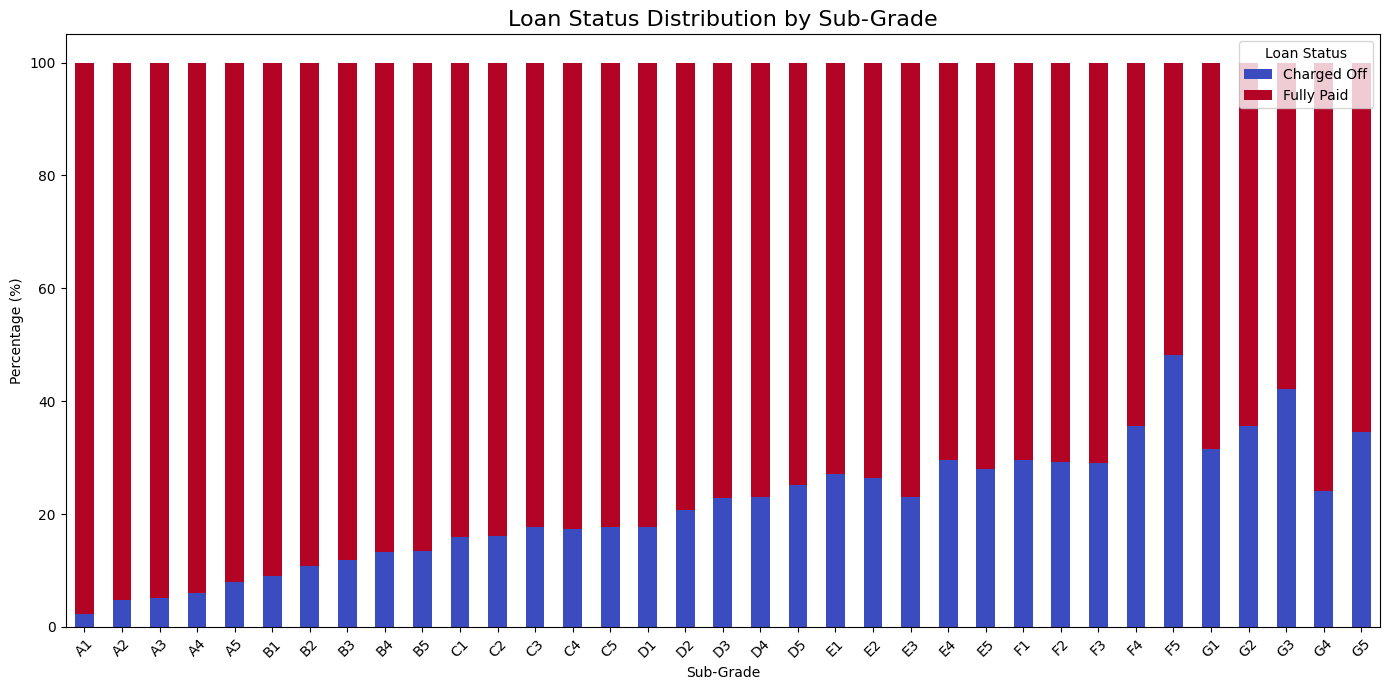

In [90]:

# Crosstab of sub_grade vs loan_status (percentages)
subgrade_crosstab = pd.crosstab(df1['sub_grade'], df1['loan_status'], normalize='index') * 100
print(subgrade_crosstab)

# Plot the distribution
plt.figure(figsize=(12,6))
subgrade_crosstab.plot(kind='bar', stacked=True, colormap='coolwarm', figsize=(14,7))
plt.title("Loan Status Distribution by Sub-Grade", fontsize=16)
plt.xlabel("Sub-Grade")
plt.ylabel("Percentage (%)")
plt.legend(title="Loan Status")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Insights
Clear Trend Across Sub-Grades
For A1 loans, only ~2% get charged off, while ~98% are fully paid.
As we move down to F5, nearly 48% get charged off, almost a 50-50 risk.
In G3, 42% are charged off (very high risk).

This shows a strong monotonic relationship between sub_grade and default risk. Lower grades (A’s) are much safer than higher grades (E–G).

Predictive Power:
Because the proportions change gradually and significantly across sub-grades, sub_grade is highly predictive of loan outcome.

For example:
A1 vs F5 → from 2% charged off to 48% charged off.
That’s a huge separation, which makes it a valuable feature.

Business Insight:
Investors can use sub_grade as a primary risk indicator.
Lending to A/B borrowers is much safer than E–G borrowers.

Sub_grade is a very strong predictor for loan_status. It should definitely be included in feature selection. In fact, it’s stronger than just grade, since it captures finer distinctions (e.g., A1 vs A5).

## 13. Debt to Income ratio vs Loan Status

loan_status  Charged Off  Fully Paid
dti_bin                             
0-5            12.279623   87.720377
5-10           12.596468   87.403532
10-15          14.279629   85.720371
15-20          15.576251   84.423749
20-25          16.632797   83.367203
25-30          13.255034   86.744966


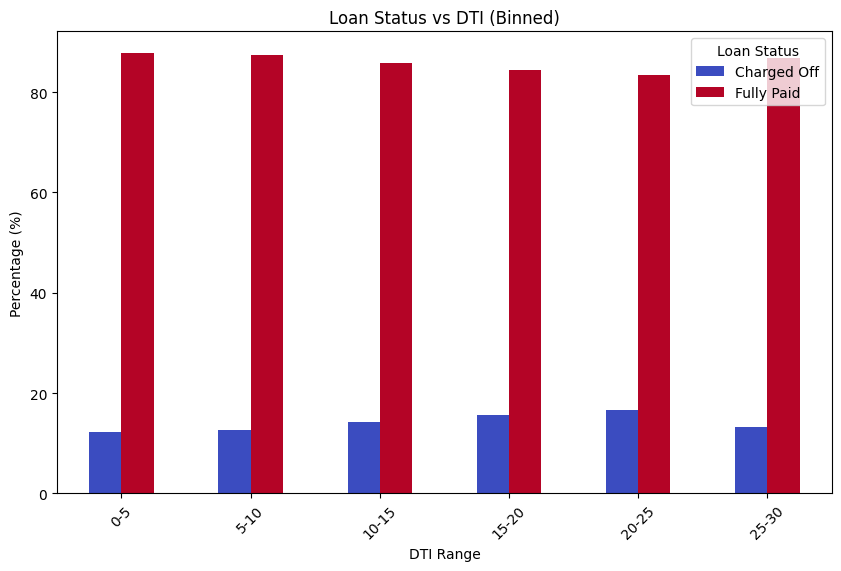

In [91]:

# Bin DTI into ranges 
bins = [0, 5, 10, 15, 20, 25, 30, 40, 50, 100]
labels = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '30-40', '40-50', '50+']
df1['dti_bin'] = pd.cut(df1['dti'], bins=bins, labels=labels, include_lowest=True)

# Crosstab: Loan status vs DTI bins (in percentages)
dti_crosstab = pd.crosstab(df1['dti_bin'], df1['loan_status'], normalize='index') * 100

print(dti_crosstab)

# Visualization
dti_crosstab.plot(kind='bar', figsize=(10,6), colormap='coolwarm')
plt.title("Loan Status vs DTI (Binned)")
plt.xlabel("DTI Range")
plt.ylabel("Percentage (%)")
plt.legend(title="Loan Status")
plt.xticks(rotation=45)
plt.show()


### Insights
0–5 DTI:
About 12.3% loans were charged-off, while 87.7% were fully paid.
This suggests borrowers with very low debt-to-income ratios are less risky.

5–10 DTI:
Charged-off rate is 12.6% (almost the same as the 0–5 group).
Still relatively safe, repayment performance is strong.

10–15 DTI:
Charged-off rises to 14.3%.
Higher risk starts to show as debt obligations increase.

15–20 DTI:
Charged-off increases further to 15.6%.
Clearer trend of riskier loans.

20–25 DTI:
Charged-off peaks at 16.6%.
Borrowers with debt burden over 20% of their income are struggling more.

25–30 DTI:
Interestingly, charged-off drops back to 13.3%.
Could indicate fewer loans issued in this DTI band, or that only stronger borrowers qualify at this range.

General Trend: As DTI increases from 0 to 25, charged-off rates tend to increase (from ~12% to ~16%).
Higher DTI = higher loan default risk.

Exception: At 25–30, charged-off drops again (~13%). This could be an artifact of fewer observations or stricter underwriting for high DTI borrowers.

Business Implication:
Borrowers with DTI ≤ 10% are the safest segment.

15–25% DTI borrowers are relatively riskier.

## 14. Number of deliquencies in the past 2 years vs loan status

loan_status  Charged Off  Fully Paid
delinq_2yrs                         
0              14.139479   85.860521
1              15.549170   84.450830
2              18.865031   81.134969
3              15.048544   84.951456
4              22.413793   77.586207
5              14.285714   85.714286
6              10.000000   90.000000
7              25.000000   75.000000
8              50.000000   50.000000
9               0.000000  100.000000
11              0.000000  100.000000


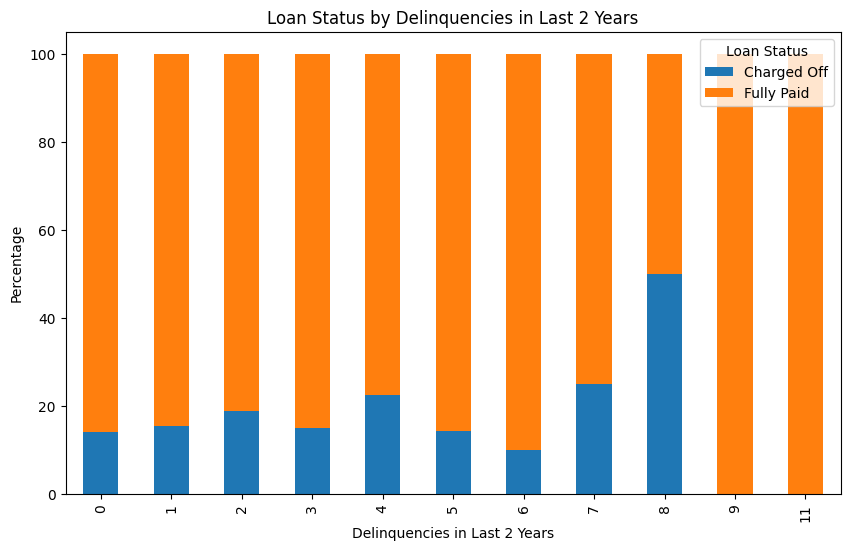

In [92]:

# Crosstab between delinq_2yrs and loan_status (percentages by row)
crosstab = pd.crosstab(df1['delinq_2yrs'], df1['loan_status'], normalize='index') * 100

print(crosstab)

# Visualization
crosstab.plot(kind="bar", stacked=True, figsize=(10,6))
plt.title("Loan Status by Delinquencies in Last 2 Years")
plt.xlabel("Delinquencies in Last 2 Years")
plt.ylabel("Percentage")
plt.legend(title="Loan Status")
plt.show()


### Insights
General Trend:
Borrowers with no delinquencies in the past 2 years (delinq_2yrs = 0) still show a 14% charge-off rate.
As delinquencies increase, the likelihood of being charged off generally increases, though not in a perfectly linear way.

Moderate Delinquencies (1–4):
1 delinquency - Charge-off rate rises to ~15.5%.
2 delinquencies - Risk jumps higher at ~18.9%.
4 delinquencies - The highest noticeable risk at 22.4% charged off.
Clear evidence that more delinquencies are associated with higher default risk.

Higher Delinquencies (5–9, 11)
5 & 6 delinquencies show surprisingly better performance (14% and 10% charge-off, respectively).
7 delinquencies - Charge-off spikes to 25%.
8 delinquencies - Even split, 50/50 charged off vs fully paid.
9 & 11 delinquencies - 100% fully paid, but these are almost certainly tiny sample sizes (very few loans, so percentages are misleading).

Key Takeaways.
0–2 delinquencies: relatively lower risk (14–19% charge-off).
3–4 delinquencies: noticeably riskier (15–22%).
7–8 delinquencies: extremely risky (25–50% charge-off).
9+ delinquencies: unreliable due to low sample sizes — not enough data to draw a conclusion.

Conclusion:
Borrowers with more delinquencies in the past 2 years generally have a higher chance of charge-off, especially around 2–4 and 7–8 delinquencies. However, rare cases with very high delinquencies don’t give stable results due to very few observations.

Takeaway:
Risk generally rises with more delinquencies, making delinq_2yrs a risk-significant feature. However, the signal is strongest in the 0–4 range; beyond that, results are unstable due to data sparsity.

## 15. Number of credit inquiries in the last 6 months vs loan status

loan_status     Charged Off  Fully Paid
inq_last_6mths                         
0                 11.959932   88.040068
1                 15.596065   84.403935
2                 16.363636   83.636364
3                 20.446735   79.553265
4                 14.900662   85.099338
5                 19.014085   80.985915
6                 25.000000   75.000000
7                 28.125000   71.875000
8                 21.428571   78.571429


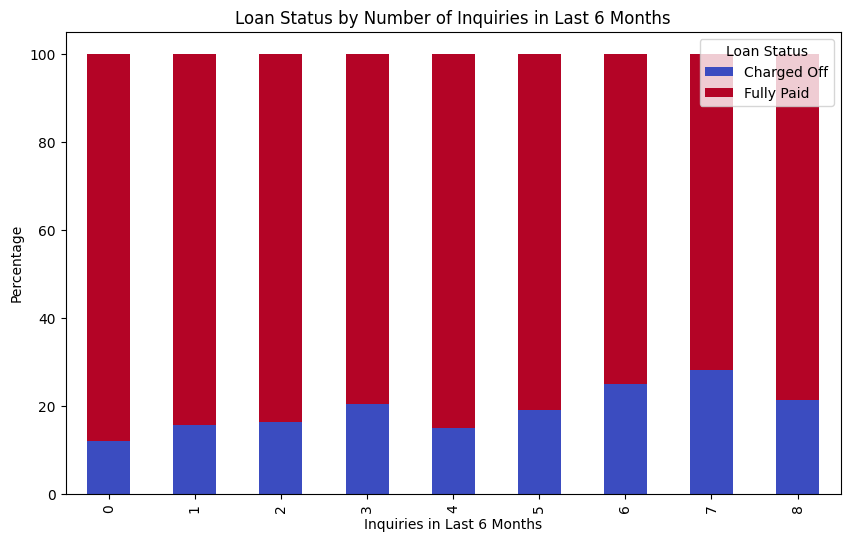

In [93]:


# Crosstab between inq_last_6mths and loan_status (normalized by row)
inq_vs_status = pd.crosstab(df1['inq_last_6mths'], df1['loan_status'], normalize='index') * 100
print(inq_vs_status)

# Visualization
inq_vs_status.plot(kind="bar", stacked=True, figsize=(10,6), colormap="coolwarm")
plt.title("Loan Status by Number of Inquiries in Last 6 Months")
plt.ylabel("Percentage")
plt.xlabel("Inquiries in Last 6 Months")
plt.legend(title="Loan Status")
plt.show()



### Insights
0 inquiries - Charged Off: 11.96% | Fully Paid: 88.04%
This is the safest group: very low risk of default.
Borrowers with no recent inquiries are most likely stable.

1–2 inquiries → ~15–16% Charged Off | ~84% Fully Paid
Risk increases slightly compared to 0, but still relatively safe.

3 inquiries → Charged Off: 20.45% | Fully Paid: 79.55%
Noticeable jump in default risk. Borrowers with 3 inquiries have ~70% higher risk of default compared to those with 0.

4–5 inquiries → ~15–19% Charged Off | ~81–85% Fully Paid
Mixed results: risk increases again around 5 inquiries.

6–8 inquiries → 21–28% Charged Off | 72–79% Fully Paid
High risk zone: borrowers with ≥6 inquiries are 2x more likely to default compared to those with 0 inquiries.

Risk Perspective
Inverse relationship: More inquiries = higher likelihood of Charged Off.
This makes sense because many recent inquiries may indicate credit hunger or financial stress, both predictors of default risk.

Feature Selection Insight
inq_last_6mths is a strong predictor of default risk.
The relationship is monotonic increasing (default probability rises with more inquiries).

## 16. Open account vs loan status

   open_acc  ChargedOffRate
0         2       21.178637
1         3       16.833811
2         4       15.558571
3         5       13.206286
4         6       13.871747
5         7       14.109948
6         8       13.931555
7         9       14.082907
8        10       14.757346
9        11       14.291188


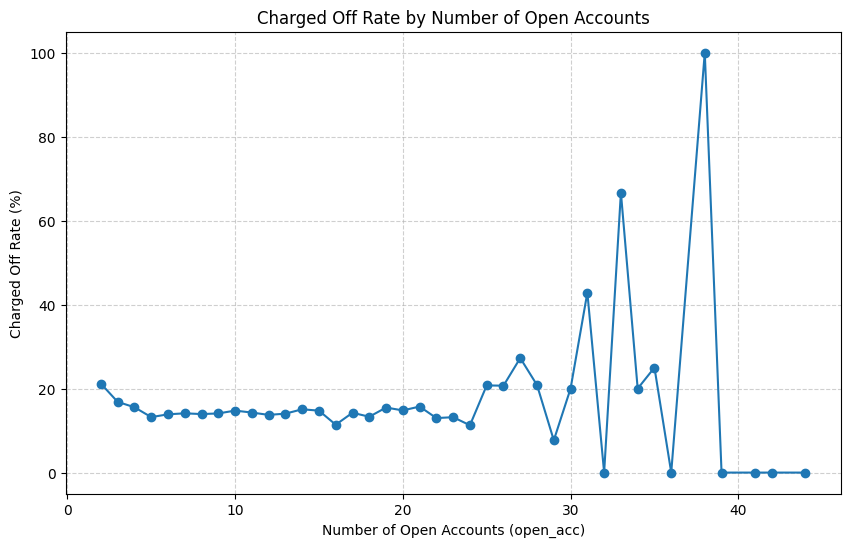

In [94]:
# Calculate Charged Off rate per open_acc
open_acc_summary = (
    df1.groupby("open_acc")["loan_status"]
    .apply(lambda x: (x == "Charged Off").mean() * 100)
    .reset_index(name="ChargedOffRate")
)

print(open_acc_summary.head(10))  # preview first 10 rows

# Visualization: line plot
plt.figure(figsize=(10,6))
plt.plot(open_acc_summary["open_acc"], open_acc_summary["ChargedOffRate"], marker="o")
plt.title("Charged Off Rate by Number of Open Accounts")
plt.xlabel("Number of Open Accounts (open_acc)")
plt.ylabel("Charged Off Rate (%)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### Insights
Low open accounts (2–5 accounts):
Charged-off rate is around 12–15%, fairly stable.
This suggests borrowers with a few accounts have a moderate but consistent risk profile.

Moderate open accounts (6–20 accounts):
Risk stays relatively flat (~13–16%) with small fluctuations.
These borrowers are generally stable — neither significantly riskier nor safer than the baseline.

High open accounts (20+ accounts):
We see much higher volatility in default rates. Some spikes reach 40–100%, though these cases are likely rare outliers (few borrowers with very high open accounts).
This suggests that borrowers with unusually high numbers of open accounts may represent a higher-risk niche group, potentially overextended or financially unstable.

Credit Risk Insight:
Normal ranges (2–20 accounts): relatively stable, default risk not heavily influenced by open accounts.
Extreme values (30+ accounts): sharp increases in default risk, but rare → may indicate special cases worth flagging.

Feature Selection Perspective:
open_acc shows some predictive value: while the bulk of borrowers have stable risk, the extremes clearly signal higher risk.


## 17. Number of derogatory public records vs loan status

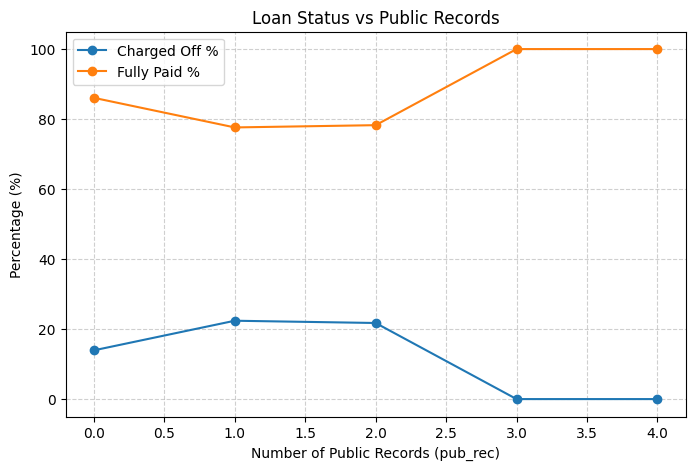

In [95]:

# Calculate default (Charged Off %) for each pub_rec value
pub_rec_summary = df1.groupby("pub_rec")["loan_status"].value_counts(normalize=True).unstack().fillna(0) * 100

# Plot Charged Off rate vs pub_rec
plt.figure(figsize=(8,5))
plt.plot(pub_rec_summary.index, pub_rec_summary["Charged Off"], marker='o', label="Charged Off %")
plt.plot(pub_rec_summary.index, pub_rec_summary["Fully Paid"], marker='o', label="Fully Paid %")

plt.xlabel("Number of Public Records (pub_rec)")
plt.ylabel("Percentage (%)")
plt.title("Loan Status vs Public Records")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


### Insights
General trend:
Borrowers with 0 public records have a higher chance of fully repaying loans (about 87%), but still show ~13% chance of default ("Charged Off").
As the number of public records increases to 1–2, the probability of default increases slightly (~22%), while the repayment rate decreases to ~78%.
However, when public records reach 3 or more, defaults drop to nearly 0%, and all loans appear as "Fully Paid".

Moderate public records (1–2): Borrowers with a small number of public derogatory records show the highest default risk.
No records (0): Still some default risk (~13%), but safer than those with 1–2 records.
High records (3–4): Surprisingly, these borrowers appear to fully repay loans, but this might be due to very few observations (small sample size effect).

Possible explanation:
Lenders may impose stricter screening or tighter loan conditions on borrowers with multiple public records, resulting in fewer loans but higher repayment among those approved.
The sharp jump to 100% repayment at 3–4 public records is likely not reliable, because of limited data points in those categories.

Conclusion:
Borrowers with 1–2 public records represent the riskiest group in terms of loan defaults. The trend beyond that (3+) is probably a data sparsity artifact rather than a real-world effect.

Risk Perspective:
0 Public Records → About 13–15% charged off, 85% fully paid.
→ Lowest risk group.

1–2 Public Records → ~20–22% charged off.
→ Higher risk compared to 0.

3–4 Public Records → Surprisingly no charged-off loans in your data (100% fully paid).
→ This looks like a data sparsity issue (too few borrowers with 3+ public records).

Interpretation:
Borrowers with 1–2 public records are riskier, while 0 records indicates safer profiles. But the 3+ records case should not be trusted—likely not enough samples.

Feature Selection Perspective:
Predictive Value:
Since charged-off % varies significantly between 0 and 1–2 records, pub_rec carries some signal about default risk.

## 18. Revolving balance vs loan status

C:\Users\Bonareri\AppData\Local\Temp\ipykernel_16020\1012270209.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  loan_dist = df1.groupby(['revol_bal_bin', 'loan_status']).size().unstack(fill_value=0)


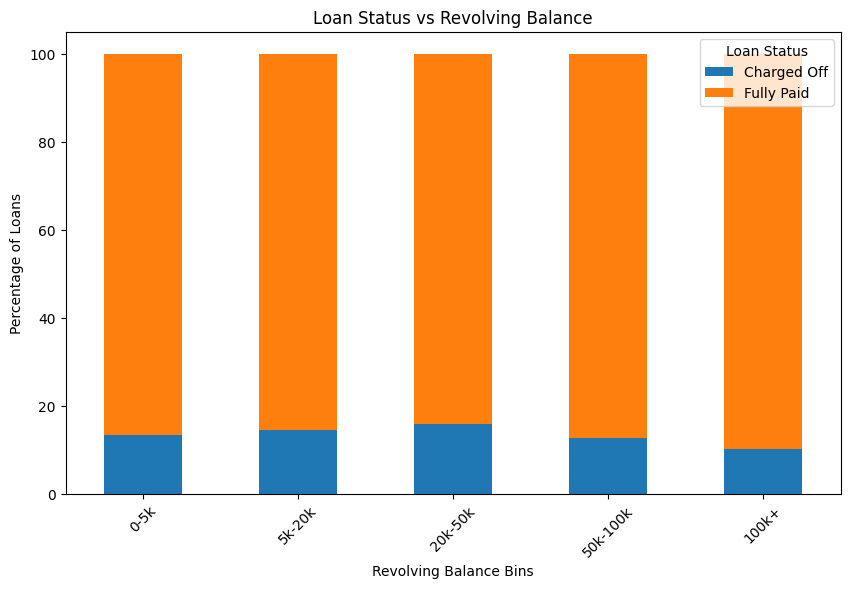

In [96]:
#  Bin revol_bal into categories
bins = [0, 5000, 20000, 50000, 100000, df1['revol_bal'].max()]
labels = ['0-5k', '5k-20k', '20k-50k', '50k-100k', '100k+']
df1['revol_bal_bin'] = pd.cut(df1['revol_bal'], bins=bins, labels=labels, include_lowest=True)

#  Group by revol_bal_bin and loan_status
loan_dist = df1.groupby(['revol_bal_bin', 'loan_status']).size().unstack(fill_value=0)

#  Normalize to get percentage distribution
loan_percent = loan_dist.div(loan_dist.sum(axis=1), axis=0) * 100

#  Plot
loan_percent.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title("Loan Status vs Revolving Balance")
plt.xlabel("Revolving Balance Bins")
plt.ylabel("Percentage of Loans")
plt.xticks(rotation=45)
plt.legend(title="Loan Status")
plt.show()


### Insights
0–5k Revolving Balance:
Charged-off rate is ~13–14%.
Borrowers with very low revolving balances tend to be safer than mid-range borrowers.

5k–50k Range:
The charged-off rate rises slightly (peaking around ~16% in 20k–50k bin).
Suggests moderate revolving balances are riskier, perhaps due to higher utilization of credit.

50k–100k Range:
Charged-off rate falls back (~13%).
Borrowers with higher balances here seem less risky — possibly because they also have higher incomes/credit limits to support it.

100k+ Revolving Balance:
Surprisingly, risk is the lowest (~10%).
These borrowers may represent wealthier clients with access to large credit lines, and thus their higher balances are not necessarily signs of distress.

Risk Perspective:
The relationship is non-linear. Moderate balances (5k–50k) show the highest default risk, while very low and very high balances show lower risk.
This suggests that revol_bal could be useful in risk models, but not in a simple linear way. It may require binning, transformations, or interaction terms with income or credit limit.

Feature Selection Perspective:
Since we see a clear variation in default rates across balance bins, revol_bal is a valuable predictor.

## 19. Revolving Utilization vs loan status

               count       mean        std  min   25%   50%    75%   max
loan_status                                                             
Charged Off   5384.0  55.750652  27.868937  0.0  34.7  58.7  79.20  99.9
Fully Paid   32113.0  47.706761  28.256453  0.0  24.1  47.8  70.94  99.9


C:\Users\Bonareri\AppData\Local\Temp\ipykernel_16020\1097918349.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="loan_status", y="revol_util", data=df1, palette="Set2")


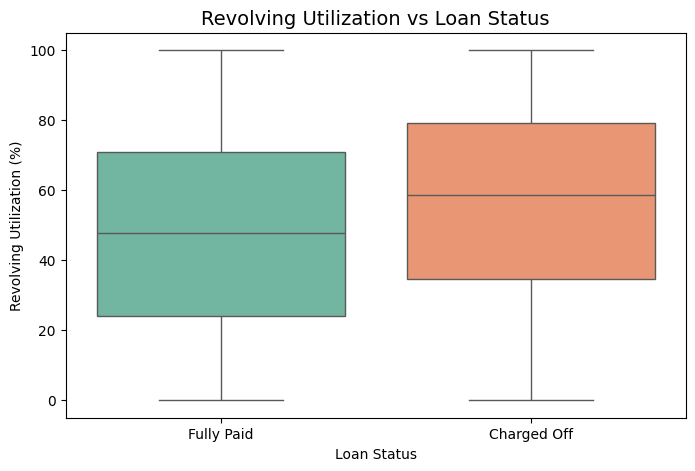

In [97]:
# Group by loan_status and check descriptive stats of revol_util
stats = df1.groupby("loan_status")["revol_util"].describe()
print(stats)

# Visualization: Boxplot of revol_util by loan status
plt.figure(figsize=(8,5))
sns.boxplot(x="loan_status", y="revol_util", data=df1, palette="Set2")
plt.title("Revolving Utilization vs Loan Status", fontsize=14)
plt.xlabel("Loan Status")
plt.ylabel("Revolving Utilization (%)")
plt.show()


### Insights
Sample size
Charged Off: 5,384 loans
Fully Paid: 32,113 loans
Much more fully paid loans, which is expected in real loan datasets.

Average revolving utilization (mean)
Charged Off: 55.75%
Fully Paid: 47.71%
On average, borrowers who defaulted (Charged Off) are using more of their available revolving credit. This is a red flag: high credit utilization is associated with repayment risk.

Spread (standard deviation)
Both groups have a std ≈ 28%, showing wide variation. Borrowers differ a lot in how much of their credit lines they use.

Percentiles (25%, 50%, 75%)
Charged Off:
Median = 58.7%, IQR = (34.7% - 79.2%)
Majority are using over half of their revolving credit.

Fully Paid:
Median = 47.8%, IQR = (24.1% - 70.9%)

More moderate utilization levels.
Maximums
Both hit ~100% utilization, meaning some borrowers maxed out their credit lines.

Risk & Feature Selection Insights:
Higher revol_util - higher default risk.
Median gap (~11%) between Charged Off and Fully Paid suggests this feature is predictive.

Should definitely be considered in a credit risk model.

Conclusion: Borrowers with high revolving utilization (≥60%) are more likely to default, making revol_util an important feature for loan risk prediction.

## 20. Total number of credit accounts vs loan status

               count       mean        std  min   25%   50%   75%   max
loan_status                                                            
Charged Off   5384.0  21.533990  11.476553  2.0  13.0  20.0  29.0  74.0
Fully Paid   32113.0  22.192601  11.400282  2.0  14.0  21.0  29.0  90.0


C:\Users\Bonareri\AppData\Local\Temp\ipykernel_16020\1112608798.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="loan_status", y="total_acc", data=df1, palette="Set2")


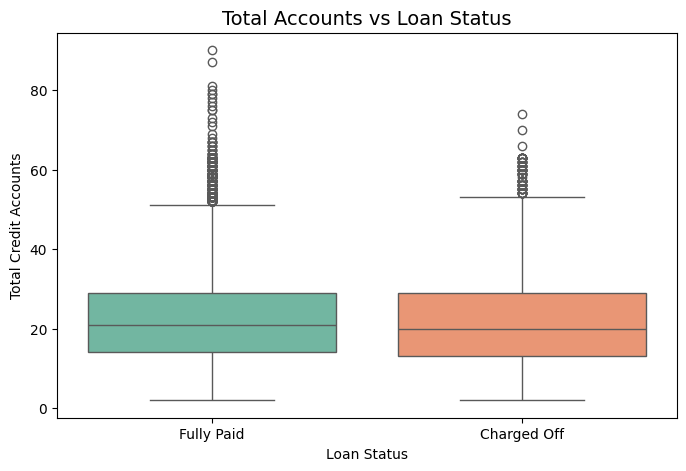

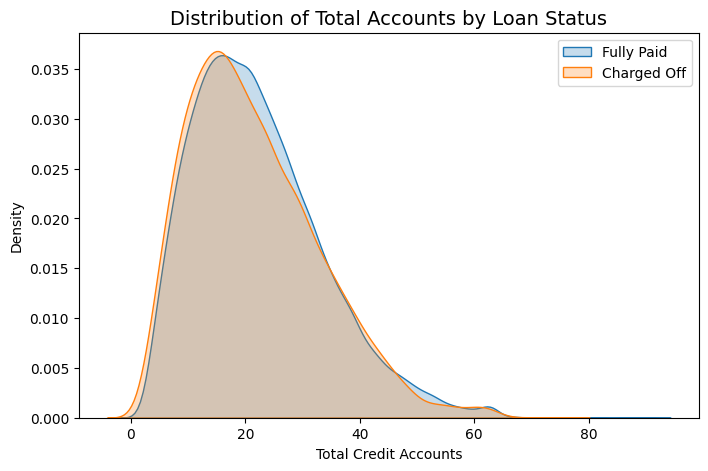

In [98]:
# Group by loan status and summarize total_acc
total_acc_summary = df1.groupby("loan_status")["total_acc"].describe()
print(total_acc_summary)

# Visualization: Boxplot to compare distributions
plt.figure(figsize=(8,5))
sns.boxplot(x="loan_status", y="total_acc", data=df1, palette="Set2")
plt.title("Total Accounts vs Loan Status", fontsize=14)
plt.ylabel("Total Credit Accounts")
plt.xlabel("Loan Status")
plt.show()

# Visualization: KDE distribution
plt.figure(figsize=(8,5))
sns.kdeplot(data=df1[df1["loan_status"]=="Fully Paid"]["total_acc"], label="Fully Paid", fill=True)
sns.kdeplot(data=df1[df1["loan_status"]=="Charged Off"]["total_acc"], label="Charged Off", fill=True)
plt.title("Distribution of Total Accounts by Loan Status", fontsize=14)
plt.xlabel("Total Credit Accounts")
plt.legend()
plt.show()


## Insights
Average number of accounts:
Borrowers who Fully Paid their loans have a slightly higher mean total_acc (22.19) compared to those who were Charged Off (21.53).
This is a very small difference, less than 1 account on average.

Median comparison:
Charged Off median = 20 accounts
Fully Paid median = 21 accounts
Again, a small difference.

Spread (Standard Deviation):
Both groups have similar spread (~11 accounts).
This means variability in the number of accounts is about the same for both groups.

Distribution overlap:
The ranges overlap heavily (2–74 vs 2–90).
This suggests total_acc is not a strong discriminator between default risk groups.

Risk & Feature Selection Insight:

Since the differences are small and overlapping, total_acc by itself is not a strong predictor of loan status.
However, in combination with other features (like revol_util, dti, income, credit history length), it might still add predictive value.



## Key Takeaway
Feature analysis indicated some features as strong predictors while others as weak predictors. We will therefore select all features since when combined and trained together our model wil perform much better

In [99]:
df1.to_csv(r"C:\Users\Bonareri\Machine_Learning_Powered_Credit_Risk_Scoring_System\data/clean_df", index=False)